In [7]:
# Importing all relevant modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, rfft, rfftfreq # For FFT
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data-Preprocessing:

<h2>Structure of the final dataset:</h2>

The data is compiled in the form of a pandas dataframe along with the sensor information and gait type as label names. Each cell of the dataframe is a list whcih contains multiple numpy arrays. Each of those numpy arrays in one list represent a sample/cycle of a single trial having a constant number of datapoints. Thus, essentially each list corresponds to the preprocessed data of a single trial of a single subject doing a particular gait (normal walking/upstairs walking/downstairs walking). Corresponding to each list, the type of gait is also stored as label name. Since scope of this project covers both acceleration and gyroscope sensor datas, 2 such dataframes are created, one for each sensor.

<h2>Parsing raw sensor data from csv files</h2>

The raw sensor data is extracted in the form of a dictionary, with the keys of the dictionary being the sanpling frequency of the corresponding csv files, and the values being the corresponding X, Y and Z time series in the csv files. The experiment names (gait types) are also extracted as a seperate list.

**Part record-wise and sample-wise sampling:**

The subject numbers vary from 150 to 274. The first 101 subjects are taken for training and testing the neural network. The last 25 subject datasets are not fed into the neural network at all and can be treated as a dataset which is completely unknown to the neural network. Once the model has been trained and tested, we can further validate our model by just passing the 25 subject data as a new test data into the neural network. In this way, we do both record wise and subject wise sampling.


In [8]:
import glob
import re
import numpy as np
import pandas as pd

#%% Global Variables
global coFreqAcc # Cut-off frequency for acceleration data
global coFreqGyr # Cut-off frequency for gyroscope data
coFreqAcc = 5 # Hz
coFreqGyr = 1 # Hz
#%% ******************* Desired Output of the Function *************************************
    # -> Sampling frequencies of all csv files being read
    # -> Time vectors of all csv files being read
    # -> X,Y,Z readings of acclerometer sensors for all subject files being read
    # -> X,Y,Z readings of gyroscope sensors for all subject files being read
    # -> All data is returned as lists




#%% ***************** Structure of the dataset:**************************
    # Home Folder -> Smartphone1
    #             -> Smartphone2
    #             -> Smartphone3 
    #                           -> subject<Subject#>_<GaitType><Trial#>
    #                                                                 -> Accelerometer.csv
    #                                                                 -> Gyroscope.csv
    #             -> Smartphone4
#********************************************************************************************



#%% Starting Data Parsing

def dataParser():
    
    print('Starting Data Parsing')
    
    # Required Subject IDs -> Which Subject Data are taken
    startSub = 150
    endSub = 250
    numSub = endSub - startSub + 1
    subjID = list(np.linspace(startSub,endSub,numSub))
    # subjID = ['155','224','257']
    
    # Accesing all folders inside the Smartphone 3 folder
    folders = glob.glob(r'./ProjectAData/Data/Smartphone3/*')  # folders is a list containing all folder names as strings
    
    
    # Initialising empty dictionary for storing all acceleration and gyroscope data
    
    # The keys in the dictionary will be the sampling frequencies and experiment names corresponding to each csv file
    # The values in the dictionary will be the 2D arrays containing the entire csv data
    
    AccData = {} # Dictionary for Acceleration data
    GyrData = {} # Dictionary for gyroscope data
    
    # Empty List for storing experiment names
    exp = []
    
    # Empty List for storing subject names
    subjNum = []
    
    
    for folder in folders:
        
        # Ensuring the impaired folders are not accessed since they don't come under our scope
        # Any folder name having the series of characters 'red' in it will be skipped
        if re.search(r'red', folder) or re.search(r'cap', folder):
            continue # The next iteration is carried out
        # print(folder)
        
        # How each folder name (folder) look like: some examples
        # ./ProjectAData/Data/Smartphone3\subject196_normal02
        # ./ProjectAData/Data/Smartphone3\subject197_downstairs01
        # ./ProjectAData/Data/Smartphone3\subject197_downstairs02
        
        # We have to ensure that we don't access any impaired folders for any of the subjects
        
        # Splitting of folder names:
            # -> Experiment Type (Upstaris, downstairs)
            # -> Subject Number
        
        Split1 = re.split('/',folder) # Splitting each folder name
        Split1 = Split1[-1]
        Split2 = re.split('_',Split1)
        experiment = Split2[-1]
        experiment = re.split('0',experiment)
        experiment = experiment[0]
        
        # Standardising the experiment names
        if re.search(r'own',experiment):
            experiment = 'downstairs'
          
        if re.search(r'up',experiment):
            experiment = 'upstairs'  
            
        if re.search(r'or',experiment):
            experiment = 'normal' 
        
        
        
        Split2 = Split2[0]
        Split3 = re.split('t',Split2)
        subjectNum = Split3[-1]
        
        
        # Accesing the accelerometer and gyroscope files for the matching subject ids
        if float(subjectNum) in subjID and float(subjectNum) != 218 and float(subjectNum) != 222 and float(subjectNum) != 270: 
            # Subject 218 folder files are not in the right format
            # Subject 222 upstairs trial 01 folder doesn't have accelerometer file so the entire subject skipped
            # Subject 270 downstairs trial 02 folder doesn't have gyroscope file so the entire subject skipped
            gyr_file = glob.glob(folder+'/Gyroscope.csv')
            acc_file = glob.glob(folder+'/Accelerometer.csv')
            
            # gyr_file and acc_file are lists of size 1 with the onky element being the path name to the corresponding
            # gyroscope or acclerometer files
            # Example:
               # ['./ProjectAData/Data/Smartphone3\\subject216_normal02/Accelerometer.csv']
               # the above is one such acc_file when the subject ID of 216 matches
            
            # print(acc_file)
            # print(gyr_file)
            # print(subjectNum)
            
            # Extracting the accelerometer and gyroscope data
            data_gyr = pd.read_csv(gyr_file[0],sep = ",", header = None) # data_gyr is a dataframe
            # From the above dataframe, we are going to extract the X,Y,Z time series and assemble it into a 2D numpy array
            # The first row of the dataframe corresponds to the headers so that has to be skipped too
            # Remember -> Indexing starts from 0
            gyr = data_gyr.iloc[1:,0:4].values.astype(float) # gyr is a 2D numpy array containing the entire csv file
            # print(data_gyr)
            # print(gyr)
            
            data_acc = pd.read_csv(acc_file[0],sep = ",", header = None)
            acc = data_acc.iloc[1:,0:4].values.astype(float) # Columns 0,1,2,3 are read (Index 4 is left out, similar to range)
            # print(data_acc)
            # print(acc)
            
            # Computing Sampling Frequency:
                # Sampling Frequency = (# Datapoints in the csv)/(Experiment Time)
                # Experiment Time = Last element of the type vector
                # # Datapoints in the csv = number of rows in the 2D array
                
            sampFreqAcc = np.shape(acc)[0]/acc[-1,0]
            sampFreqGyr = np.shape(gyr)[0]/gyr[-1,0]
            
            # Due to some errors in data measurement, some sampling frequencies have blatantly wrong values (for eg. 0.3 Hz)
            # Since for using digital filters, we require the digital filter critical frequency to be between 0 and 1
            if sampFreqAcc < 2*coFreqAcc or sampFreqGyr < 2*coFreqGyr:
                continue # The entire subject is skipped
            
            
            # Dictionary keys have to be immutable only (like tuples)
            keyAcc = sampFreqAcc
            keyGyr = sampFreqGyr
            
            # Adding elements to the acceleration and gyroscope dictionaries
            AccData[keyAcc] = acc # The accelerometer file sampling frequency is the key and the csv data is the value
            GyrData[keyGyr] = gyr # The gyroscope file sampling frequency is the key and the csv data is the value
            
            # Appending experiment names to the experiment list
            exp.append(experiment)
            
            # Appending subject names to the subject list
            subjNum.append(subjectNum)
            
            # Printing the subject numbers and corresponding experiments whose files are accessed for reference
            print(subjectNum,experiment)
            
    # print(AccData)
        
    print('Ending Data Parsing')
    return AccData, GyrData, exp, subjNum

<h2>Data Filtering</h2>

Fast fourier transforms can be used to judge the cut-off frequencies required to effectively filter out noise in the raw sensor data. A fourth order butterworth low pass filter is used. Based on the frequency domain plots obtained from FFT, we can set a standard cut-off frequencies for each of the sensor data. Even though different activities will tend to have different appropriate cut-off frequencies (for example, downstairs walking will tend to have more *jerky* movements and thus will have higher constituent frequencies than normal even walking), we can still use a standard cut-off frequency for all gaits since we will be inputing time series in the neural network which means *pattern recognition* becomes the main learning task for the neural network. Thus, even though some valuable information may be lost due to low cut-off frequencies for gait trials like downstairs walking, the overall gait patttern which needs to be recognised will stay the same. 

In [9]:
# Function for data filtering
#**************************** Filtering Data *********************************
# Filter Used: 4th Order Low Pass Butterworth Filter


# Importing the signal module from Scipy
from scipy import signal

def dataFilter(in_signal,order,coFreq,sampFreq):
    
    [b,a] = signal.butter(order,coFreq/(sampFreq/2),'low')
    out_signal = signal.filtfilt(b,a,in_signal)
    return out_signal

<h2>Extracting Motion Sequence</h2>

For all the trials, the data at the beginning and the end of the trial will most likely be garbage data since at the start of the trial, the subject prepares to start walking and at the end of the trial, the subject abruptly stops. Thus, the actual motion is usually not reflected in these instances of the data and thus these instances need to be cut out.

In [10]:
# Function for extracting motion sequence

# Modules
import numpy as np
# import matplotlib.pyplot as plt
from scipy import signal

#%% Function For cutting the data and extracting Motion Sequence

#%% Primarliy the data aat the beginning of the trials have to be left out since
# there may have been some lag in starting the movement at the start of the trials
# and thus the starting data won't be a part of the motion sequence
# Similarly with the end few datapoints when the subject is finishing the trials


# Data is cut based on the occurance of peaks in the data
# The norms of the data are taken along the rows i.e.:
    # Sample Acceleration Data as 2D array:
        #accX   accY    accZ
        #acc_abs(for one row) = square summation of accX, accY and accZ
    # By usig norms, we get one time series with the value of each element in
    # the series being the norm across the rows (X,Y and Z)
        
#%% Function Definition

# Empty placeholder lists
accEmp = []
gyrEmp = []

def dataCut(acc, gyr, accfreq, gyrfreq): # 2D arrays containing data in all 3D coordinates are input to te function
    # Taking norms across columns in each row and converting into one time series
    acc_abs = np.linalg.norm(acc,axis = 1)
    # fig = plt.figure(figsize = (10,10))
    # plt.plot(acc_abs)
    
    # The peaks having having height lesser than 11 m/s2 are not considered
    peaks, _ = signal.find_peaks(acc_abs,height=11) # peaks will be the index numbers at which the peaks (local maxima) occur
    diff_peaks = np.diff(peaks) # diff_peaks gives us the diffference between the index numbers of consecutive peaks
    gap1  = np.argmax(diff_peaks[:20]) # Largest difference index number betwween consecutive peak indices in the first 20 peaks
    gap2  = np.argmax(diff_peaks[-10:]) # Largest difference index number betwween consecutive peak indices in the last 10 peaks
    gap2  = int(gap2 + np.shape(diff_peaks)[0]-10) # gap2 index number is defined wrt start of the indices 

    if (gap2 + np.shape(diff_peaks)[0]) < 11: # For some datasets, the gap2 index becomes negative, those datasets are omitted
        return accEmp,gyrEmp
    
    else:
        # Extracted Motion Sequence
        acc_cut = acc[peaks[gap1+1]:peaks[gap2],:]
        gyr_cut = gyr[peaks[gap1+1]:peaks[gap2],:]
    
        print('Motion Sequence Extracted')
    
        return acc_cut, gyr_cut # Cut 2D arrays returned


<h2>Reducing dimensionality and rotating the data</h2>

Since the orientation of the phones were not standardised and fixed while taking the data, the sensor data values across all trials are not with respect to a standard inertial frame. Thus, the data across all trials needs to be rotated properly. Additionally, it also makes sense to reduce the dimensionality of the data.

In this project, 2 such methods are looked at:
* Principle Component Analysis
* Root Mean Sqaure of nornalised data points

A standard python module and code base is used to apply the principle component analysis. For normalising the dataset, the means of X, Y and Z time series are computed and the distribution of datasets about the mean are computed. Once, the data is normalised, the RMS of the data is computed.


<h2>Segmentation of data into sample/cycles</h2>

In [11]:
#%% Function for segmenting the data

from scipy import signal
import numpy as np

#%% Function Definition
def dataSegment(acc,gyr,rot):
    
    if rot == 'PCA':
        # Peak Finding when PCA is used
        peaksAcc, _ = signal.find_peaks(acc,height = 2) # Returns indices of peaks in acceleration data
        peaksGyr, _ = signal.find_peaks(gyr,height = 1.4) # Returns indices of peaks in gyroscope data
        
    elif rot == 'RMS':
        # Peak Finding when RMS of normalised values are used
        peaksAcc, _ = signal.find_peaks(acc,height = 1.2) # Returns indices of peaks in acceleration data
        peaksGyr, _ = signal.find_peaks(gyr,height = 0.4) # Returns indices of peaks in gyroscope data
    
    
    # We return a list wherer each element of the list is the individual cycle/sample
    # The data arrays are sliced into multiple cycles on the basis of peak indices obtained
    
    # Initialising lists
    segAcc = []
    segGyr = []
    
    
    jj = 0
    for ii in peaksAcc:
        cycAcc = acc[jj:ii + 1] # Cycle obtained as array
        cycAcc = signal.resample(cycAcc,100)
        segAcc.append(cycAcc)
        jj = ii + 1
        #print(segAcc,type(segAcc))
            
        
        
    jj = 0
    for ii in peaksGyr:
        cycGyr = gyr[jj:ii + 1] # Cycle obtained 
        cycGyr = signal.resample(cycGyr,100)
        segGyr.append(cycGyr)
        jj = ii + 1

    return segAcc,segGyr # Lists with each elements being the segmented cycles are returned


<h2>Removing Malicious Data</h2>

Cycles which are blatantly wrong i.e. donot follow the general trend of the cycles are ommitted from the data. The logic used for ommision is based on the gaussian distribution of means of each cycle datapoints. All cycles having their datapoint means lying outside 34% on both sides of the overall cycle mean were omitted.

In [15]:
# Function Script for main data preprocessing


# Importing Modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, rfft, rfftfreq # For FFT
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint



from dataParser import dataParser # importing the function for reading all the csv files
# Importing data filtering function
from dataFilter import dataFilter
# Importing data cutting function
from dataCut import dataCut
# Importing data segmenting function
from dataSegment import dataSegment



#%% Global Variables
global coFreqAcc # Cut-off frequency for acceleration data
global coFreqGyr # Cut-off frequency for gyroscope data
coFreqAcc = 5 # Hz
coFreqGyr = 1 # Hz
    
#%% Method for Rotating and Standardising Data
# 1). PCA (principle component analysis) -> 'PCA'
# 2). RMS of normalised time series -> 'RMS'
    
rot = 'PCA'
    
#%% Dataframes for accumulating data
colNames = ['Gait','Subject']
accData = pd.DataFrame(columns = colNames) # Dataframe for accelerometer values
gyrData = pd.DataFrame(columns = colNames) # Dataframe for gyroscope values
finalData = pd.DataFrame(columns = colNames) # Dataframe for all sensor values
    
    
#%% Obtaining all pertinent data for the mentioned subject numbers
AccData,GyrData,experiments,subjNum = dataParser()
    
# All sampling Frequencies
sampfreqAcc = list(AccData.keys()) # All acceleration files sampling frequencies
sampfreqGyr = list(GyrData.keys()) # All gyroscope files sampling frequencies
    
# All csv data
acc = list(AccData.values())
gyr = list(GyrData.values())

Starting Data Parsing
150 downstairs
150 downstairs
150 normal
150 normal
150 upstairs
150 upstairs
151 downstairs
151 downstairs
151 normal
151 normal
151 upstairs
151 upstairs
152 downstairs
152 downstairs
152 normal
152 normal
152 upstairs
152 upstairs
153 downstairs
153 downstairs
153 normal
153 normal
153 upstairs
153 upstairs
154 downstairs
154 downstairs
154 normal
154 normal
154 upstairs
154 upstairs
155 downstairs
155 downstairs
155 normal
155 normal
155 normal
155 upstairs
155 upstairs
156 normal
156 normal
157 downstairs
157 downstairs
157 normal
157 normal
157 upstairs
157 upstairs
158 normal
159 downstairs
159 downstairs
159 normal
159 normal
159 upstairs
159 upstairs
160 downstairs
160 downstairs
160 normal
160 normal
160 upstairs
160 upstairs
162 downstairs
162 downstairs
162 normal
162 normal
162 upstairs
162 upstairs
163 normal
163 normal
163 upstairs
163 upstairs
164 normal
164 normal
164 upstairs
164 upstairs
165 downstairs
165 downstairs
165 normal
165 normal
165 up

<h2>Using Fast Fourier Transforms to judge the appropriate cut-off frequencies for Accelerometer and Gyroscope Sensor Data</h2>

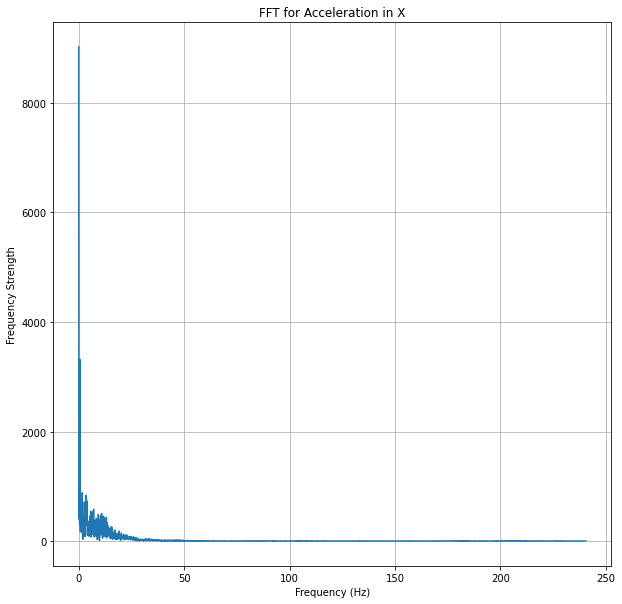

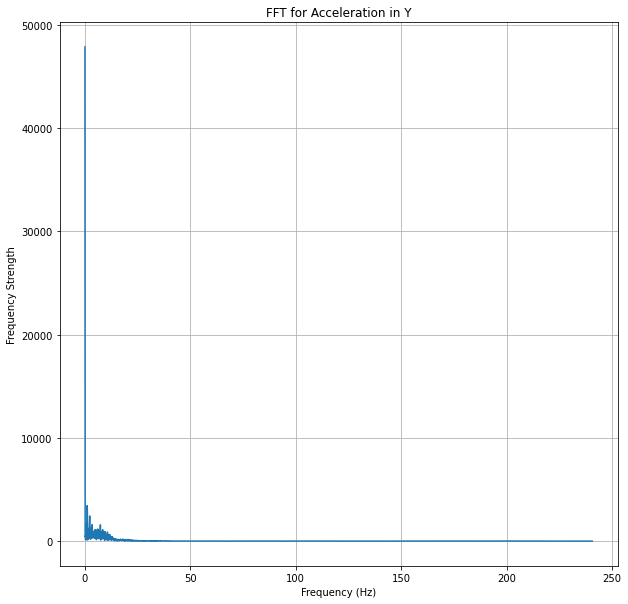

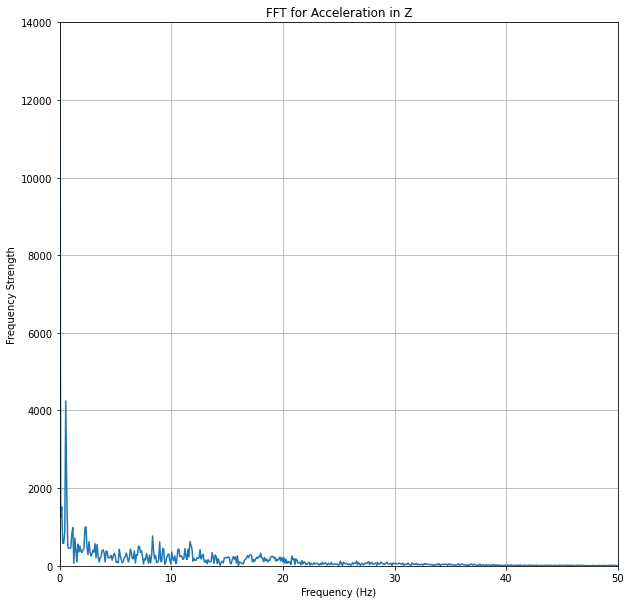

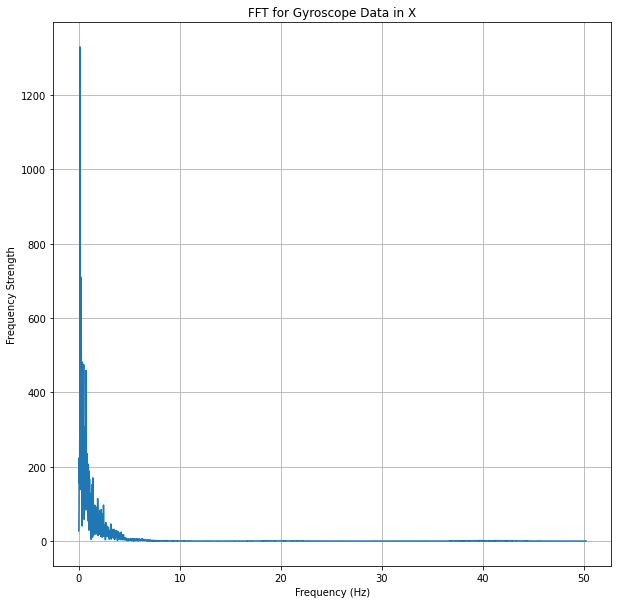

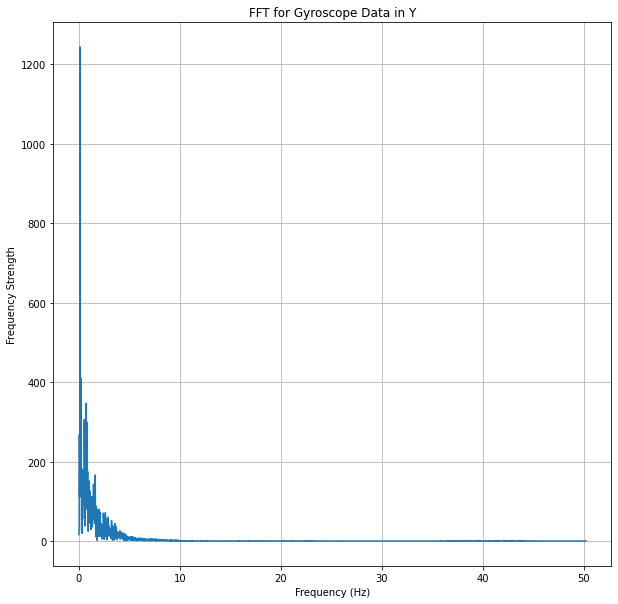

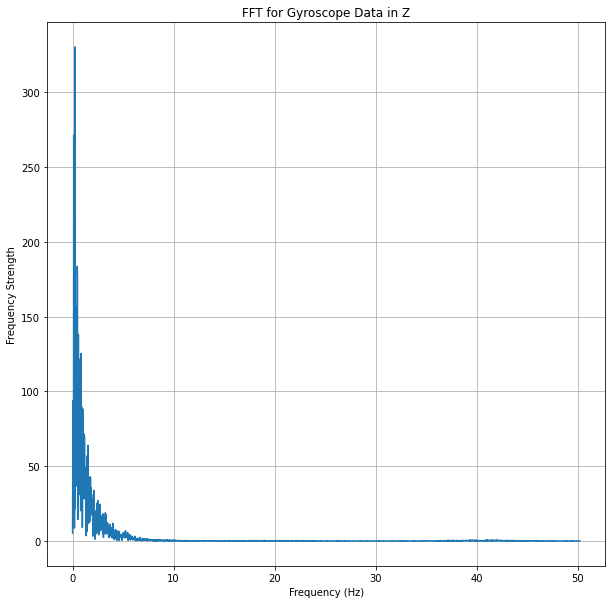

In [18]:
# Deciding cut-off frequency for filtering
# Using FFT (Fast Fourier Transform)
# The frequency for which the frequency strength stops having significant peaks, that can 
# be assumed to be the cut-off frequency
    
# =============================================================================

# Sample Raw Data

ax = acc[1][:,1]
ay = acc[1][:,2]
az = acc[1][:,3]
ta = acc[1][:,0]

gx = gyr[1][:,1]
gy = gyr[1][:,2]
gz = gyr[1][:,3]
tg = gyr[1][:,0]



yfx = rfft(ax) # rfft(Raw Signal)
xfx = rfftfreq(np.size(ax),1/sampfreqAcc[1]) # rfftfreq(#Datapoints, 1/sampling frequency)
fig = plt.figure(figsize = (10,10))
plt.plot(xfx,abs(yfx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Strength')
plt.title('FFT for Acceleration in X')
plt.grid()
# plt.axis([0,50,0,14000])
yfy = rfft(ay) # rfft(Raw Signal)
xfy = rfftfreq(np.size(ay),1/sampfreqAcc[1]) # rfftfreq(#Datapoints, 1/sampling frequency)

fig = plt.figure(figsize = (10,10))
plt.plot(xfy,abs(yfy))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Strength')
plt.title('FFT for Acceleration in Y')
plt.grid()
# plt.axis([0,50,0,14000])

yfz = rfft(az) # rfft(Raw Signal)
xfz = rfftfreq(np.size(az),1/sampfreqAcc[1]) # rfftfreq(#Datapoints, 1/sampling frequency)

fig = plt.figure(figsize = (10,10))
plt.plot(xfz,abs(yfz))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Strength')
plt.title('FFT for Acceleration in Z')
plt.grid()
plt.axis([0,50,0,14000])


yfxg = rfft(gx) # rfft(Raw Signal)
xfxg = rfftfreq(np.size(gx),1/sampfreqGyr[10]) # rfftfreq(#Datapoints, 1/sampling frequency)
fig = plt.figure(figsize = (10,10))
plt.plot(xfxg,abs(yfxg))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Strength')
plt.title('FFT for Gyroscope Data in X')
plt.grid()

yfyg = rfft(gy) # rfft(Raw Signal)
xfyg = rfftfreq(np.size(gy),1/sampfreqGyr[10]) # rfftfreq(#Datapoints, 1/sampling frequency)


fig = plt.figure(figsize = (10,10))
plt.plot(xfyg,abs(yfyg))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Strength')
plt.title('FFT for Gyroscope Data in Y')
plt.grid()

yfzg = rfft(gz) # rfft(Raw Signal)
xfzg = rfftfreq(np.size(gz),1/sampfreqGyr[10]) # rfftfreq(#Datapoints, 1/sampling frequency)

fig = plt.figure(figsize = (10,10))
plt.plot(xfzg,abs(yfzg))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Strength')
plt.title('FFT for Gyroscope Data in Z')
plt.grid()

**From the above FFT plots, it can be observed that the gyroscope data tends to have a little lower cut-off frequencies as compared to their corresponding accelerometer sensor data.**

By using FFT, we can set a standard cut-off frequency for all the sensor data points. The cutoff frequencies chosen by us for the accelerometer sensor values was *5 Hz* and for the gyroscope sensor values was *1 Hz*. A very important advantage we can leverage out of such low cut-off frequencies is the fact that we can segment our data into finite number of samples/cycles much easier if the data curves are smooth.

<h2>Filtering the Data</h2>

In [20]:
#%% Filtering the Data
for i in range(0,len(acc)):
    acc[i][:,1] = dataFilter(acc[i][:,1],4,coFreqAcc,sampfreqAcc[i])
    acc[i][:,2] = dataFilter(acc[i][:,2],4,coFreqAcc,sampfreqAcc[i])
    acc[i][:,3] = dataFilter(acc[i][:,3],4,coFreqAcc,sampfreqAcc[i])
        
for j in range(0,len(gyr)):
    gyr[j][:,1] = dataFilter(gyr[j][:,1],4,coFreqGyr,sampfreqGyr[j])
    gyr[j][:,2] = dataFilter(gyr[j][:,2],4,coFreqGyr,sampfreqGyr[j])
    gyr[j][:,3] = dataFilter(gyr[j][:,3],4,coFreqGyr,sampfreqGyr[j])
        
        
print('Data Filtered')

Data Filtered


<h2>Plotting Filtered Data</h2>

Filtered Acceleration Plotted
Filtered Angular Velocity Plotted


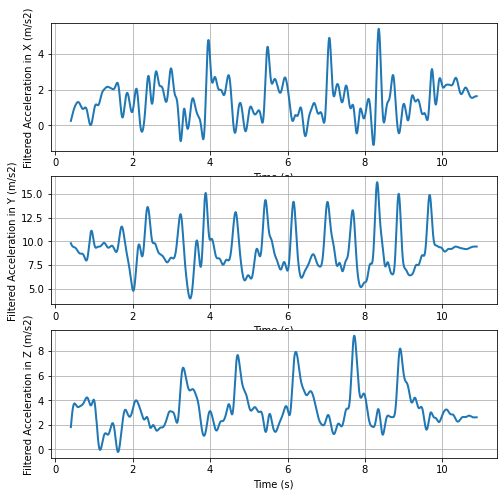

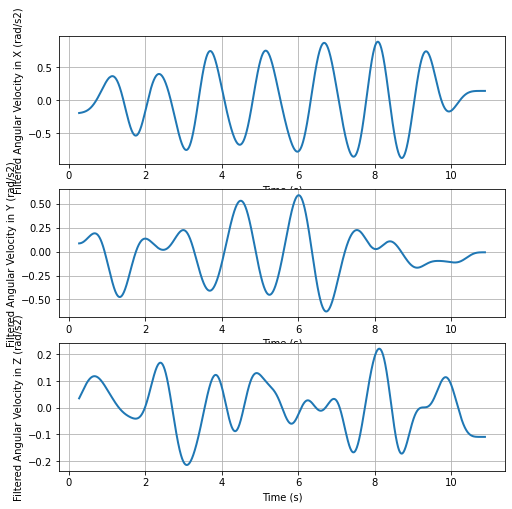

In [22]:
fig,(axis1,axis2,axis3) = plt.subplots(nrows = 3, ncols = 1, figsize = (8,8))
    
axis1.plot(acc[0][:,0],acc[0][:,1],linewidth = 2)
axis1.set_xlabel('Time (s)')
axis1.set_ylabel('Filtered Acceleration in X (m/s2)')
# axis1.axis([0,30,-15,15])
axis1.grid()
    
axis2.plot(acc[0][:,0],acc[0][:,2],linewidth = 2)
axis2.set_xlabel('Time (s)')
axis2.set_ylabel('Filtered Acceleration in Y (m/s2)')
axis2.grid()
    
axis3.plot(acc[0][:,0],acc[0][:,3],linewidth = 2)
axis3.set_xlabel('Time (s)')
axis3.set_ylabel('Filtered Acceleration in Z (m/s2)')
axis3.grid()
print('Filtered Acceleration Plotted')
    
    
fig,(axis1,axis2,axis3) = plt.subplots(nrows = 3, ncols = 1, figsize = (8,8))
    
axis1.plot(gyr[0][:,0],gyr[0][:,1],linewidth = 2)
axis1.set_xlabel('Time (s)')
axis1.set_ylabel('Filtered Angular Velocity in X (rad/s2)')
axis1.grid()
    
    
axis2.plot(gyr[0][:,0],gyr[0][:,2],linewidth = 2)
axis2.set_xlabel('Time (s)')
axis2.set_ylabel('Filtered Angular Velocity in Y (rad/s2)')
axis2.grid()
    
axis3.plot(gyr[0][:,0],gyr[0][:,3],linewidth = 2)
axis3.set_xlabel('Time (s)')
axis3.set_ylabel('Filtered Angular Velocity in Z (rad/s2)')
axis3.grid()
print('Filtered Angular Velocity Plotted')  


<h2>Further Pre-Processing Steps</h2>

The data is now put through the following steps:
* Cutting the data and extracting motion sequence
* Rotating and reducing dimensionality of the data using 2 methods:
    * Princicple Component Analysis
    * Root Mean Square
* Segmenting the time series into cycles/samples with each cycle containing 100 datapoints
* Storing the datapoints in a Pandas dataframe such that it can be input into the neural network.

In [24]:
#%% Further Preprocessing
# Empty List for New Processed acceleration data
acc1 = []
# Empty List for New Processed gyroscope data
gyr1 = []
    
countA = 0
firstsegAcc = []
firstsegGyr = []
for i in range(0,len(acc)):
    #%% Cutting Data
    acc_cut,gyr_cut = dataCut(acc[i][:,1:4],gyr[i][:,1:4],sampfreqAcc[i],sampfreqGyr[i])
        
    if len(acc_cut) == 0 or len(gyr_cut) == 0:
        continue
        
    if np.shape(gyr_cut)[0] == 0 or np.shape(acc_cut)[0] == 0: # Some issues in some trials where gyroscope data vanishes
                                      # after cutting the data -> Trials where that is happening 
                                      # are omitted for now
        continue
        
    #%% Rotating and Reducing Dimensionality of Data -> Principle Component Analysis
        
    if rot == 'PCA':
            
        data_gyr = scale(gyr_cut)
        pca_gyr = decomposition.PCA(n_components=1) # Number of prinicple component axes = 1
        pca_gyr.fit(data_gyr)
        trans_gyr = pca_gyr.transform(data_gyr)
        # trans_df_gyr = pd.DataFrame(trans_gyr)
        data_acc = scale(acc_cut)
        pca_acc = decomposition.PCA(n_components=1)
        pca_acc.fit(data_acc)
        trans_acc = pca_acc.transform(data_acc)
        # trans_df_acc = pd.DataFrame(trans_acc)
            
            
    # Rotating and Reducing Dimensionality of Data -> RMS Time series    
            
    elif rot == 'RMS':
        
        # Normalising the data
            
        # Acceleration
        # Means of X,Y,Z time series
        x_mean = np.mean(acc_cut[:,0])
        y_mean = np.mean(acc_cut[:,1])
        z_mean = np.mean(acc_cut[:,2])
            
        # Max of X,Y,Z time series
        x_max = np.max(acc_cut[:,0])
        y_max = np.max(acc_cut[:,1])
        z_max = np.max(acc_cut[:,2])
            
        trans_acc = np.empty((np.shape(acc_cut)[0],1)) # empty array for storing the RMS time series of acceleration data
            
        # Normalised Data -> Between -1 and 1
        # Values smaller than mean will be in [-1,0] and values greater than mean will be [0,1]
        for ii in range(0,np.shape(acc_cut)[0]):
        
            x_norm = (acc_cut[ii,0] - x_mean)/(x_max - x_mean)
            y_norm = (acc_cut[ii,0] - y_mean)/(y_max - y_mean)
            z_norm = (acc_cut[ii,0] - z_mean)/(z_max - z_mean)
                
            trans_acc[ii] = np.sqrt((np.power(x_norm,2) + np.power(y_norm,2) + np.power(z_norm,2))/(3))
                
                
        # Gyroscope
        # Means of X,Y,Z time series
        x_mean = np.mean(gyr_cut[:,0])
        y_mean = np.mean(gyr_cut[:,1])
        z_mean = np.mean(gyr_cut[:,2])
            
        # Max of X,Y,Z time series
        x_max = np.max(gyr_cut[:,0])
        y_max = np.max(gyr_cut[:,1])
        z_max = np.max(gyr_cut[:,2])
            
        trans_gyr = np.empty((np.shape(gyr_cut)[0],1)) # empty array for storing the RMS time series of acceleration data
            
        # Normalised Data -> Between -1 and 1
        # Values smaller than mean will be in [-1,0] and values greater than mean will be [0,1]
        for ii in range(0,np.shape(gyr_cut)[0]):
        
            x_norm = (gyr_cut[ii,0] - x_mean)/(x_max - x_mean)
            y_norm = (gyr_cut[ii,0] - y_mean)/(y_max - y_mean)
            z_norm = (gyr_cut[ii,0] - z_mean)/(z_max - z_mean)
            
            trans_gyr[ii] = np.sqrt((np.power(x_norm,2) + np.power(y_norm,2) + np.power(z_norm,2))/(3))
                
            
            
                
        
    #%% Segmenting the data and resampling the cycles
    segAcc, segGyr = dataSegment(trans_acc[:,0],trans_gyr[:,0],rot)
    
        
    if i == 6:
        firstsegAcc = segAcc
        firstsegGyr = segGyr
    
        
        
    #%% Removing Malicious Data
        
    # Array for storing mean of each cycle
    meanCycle = np.zeros(len(segAcc))
    for ii in range(0,len(segAcc)):
        meanCycle[ii] = np.mean(segAcc[ii])
            
    meanCycleMean = np.mean(meanCycle) # Mean of all cycle means
        
    # Standard Deviation of cycle means wrt mean of cycle means
    sigma = np.std(meanCycle)
        
    segAcc_nonmal =[]
        
    for ii in range(0,meanCycle.shape[0]):
        if meanCycle[ii] >= (meanCycleMean + sigma) or meanCycle[ii] <= (meanCycleMean - sigma):
            continue # The particular cycle is removed
        else:
            segAcc_nonmal.append(segAcc[ii]) # List containing non-malicious cycles as arrays
                
        
    # Array for storing mean of each cycle
    meanCycle = np.zeros(len(segGyr))
    for iter in range(len(segGyr)):
        meanCycle[iter] = np.mean(segGyr[iter])
            
    meanCycleMean = np.mean(meanCycle) # Mean of all cycle means
        
    # Standard Deviation of cycle means wrt mean of cycle means
    sigma = np.std(meanCycle)
        
    segGyr_nonmal = []
        
    for ii in range(len(segGyr)):
        if meanCycle[ii] >= (meanCycleMean + sigma) or meanCycle[ii] <= (meanCycleMean - sigma)  :
            continue # The particular cycle is removed
        else:
            segGyr_nonmal.append(segGyr[ii]) # List containing non-malicious cycles as arrays
                
    # Attempting to modify the list contents of the cycles so that acceleration cycles and 
    # Gyroscope cycles are equal in number
        
    if len(segAcc_nonmal) > len(segGyr_nonmal): # if there are more acceleration cycles than gyroscope cycles
        segAcc_nonmal = segAcc_nonmal[0:len(segGyr_nonmal)] # acceleration cycles are cut down
            
    elif len(segGyr_nonmal) > len(segAcc_nonmal): # if there are more gyroscope cycles than acceleration cycles
        segGyr_nonmal = segGyr_nonmal[0:len(segAcc_nonmal)] # gyroscope cycles are cut down
        
    for ii in range(0,len(segAcc_nonmal)): # segGyr_nonmal can be used to since both are of same length
        for jj in range(0,segAcc_nonmal[ii].shape[0]):
            finalData.loc[countA + ii,jj+2] = segAcc_nonmal[ii][jj]
                
        for kk in range(0,segGyr_nonmal[ii].shape[0]):
            finalData.loc[countA + ii,jj + 3 + kk] = segGyr_nonmal[ii][kk]
        finalData.at[countA + ii,'Gait'] = experiments[i]
        finalData.at[countA + ii,'Subject'] = subjNum[i]
                
    countA = countA + ii + 1
        
    
    # Data stores alternatively as lists
    acc1.append(segAcc_nonmal)
    gyr1.append(segGyr_nonmal)

Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted


C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\pandas\core\indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Seque

C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Seque

C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\HP\anaconda3\envs\CIE21\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Sequence Extracted
Motion Seque

<h2>Visualising Cut Data</h2>

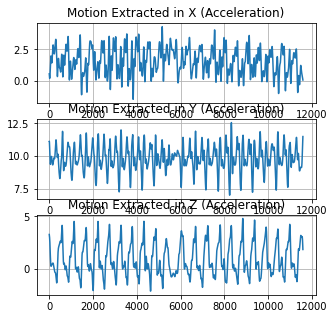

In [28]:
fig,(axis1,axis2,axis3) = plt.subplots(nrows = 3, ncols = 1, figsize = (5,5))

axis1.plot(acc_cut[:,0])
axis1.set_title('Motion Extracted in X (Acceleration)')
axis1.grid()
axis2.plot(acc_cut[:,1])
axis2.set_title('Motion Extracted in Y (Acceleration)')
axis2.grid()
axis3.plot(acc_cut[:,2])
axis3.set_title('Motion Extracted in Z (Acceleration)')
axis3.grid()

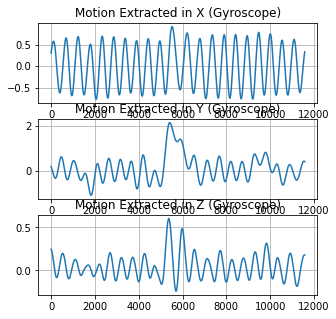

In [27]:
fig,(axis1,axis2,axis3) = plt.subplots(nrows = 3, ncols = 1, figsize = (5,5))

axis1.plot(gyr_cut[:,0])
axis1.set_title('Motion Extracted in X (Gyroscope)')
axis1.grid()
axis2.plot(gyr_cut[:,1])
axis2.set_title('Motion Extracted in Y (Gyroscope)')
axis2.grid()
axis3.plot(gyr_cut[:,2])
axis3.set_title('Motion Extracted in Z (Gyroscope)')
axis3.grid()

<h2>Visualising rotated data</h2>

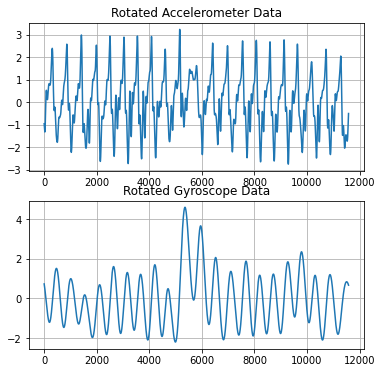

In [29]:
fig,(axis1,axis2) = plt.subplots(nrows = 2, ncols = 1, figsize = (6,6))

axis1.plot(trans_acc[:,0])
axis1.set_title('Rotated Accelerometer Data')
axis1.grid()

axis2.plot(trans_gyr[:,0])
axis2.set_title('Rotated Gyroscope Data')
axis2.grid()

<h2>Visualising Segmented Data</h2>

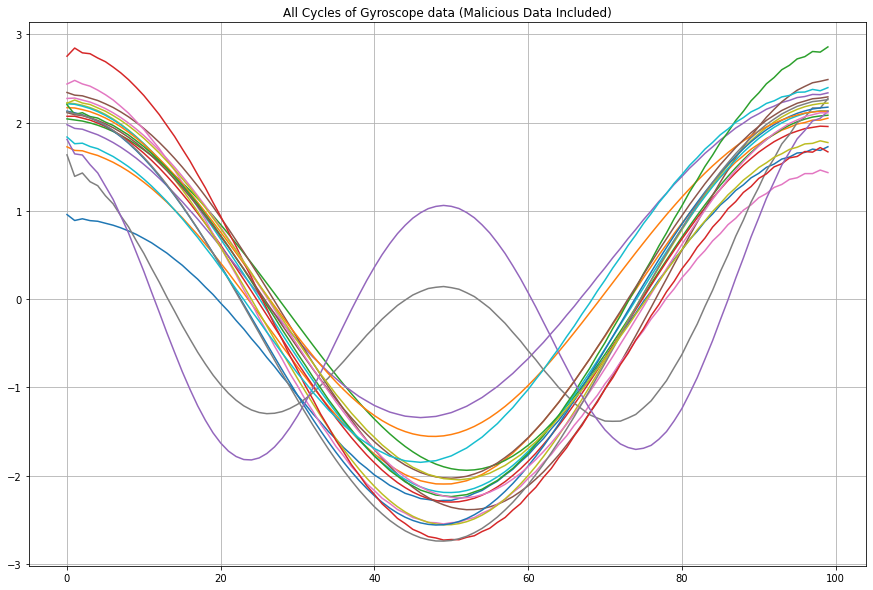

In [45]:
fig = plt.figure( figsize = (15,10))


for i in range(0,len(firstsegGyr)):
    plt.plot(firstsegGyr[i])
plt.title('All Cycles of Gyroscope data (Malicious Data Included)')
plt.grid()
plt.show()



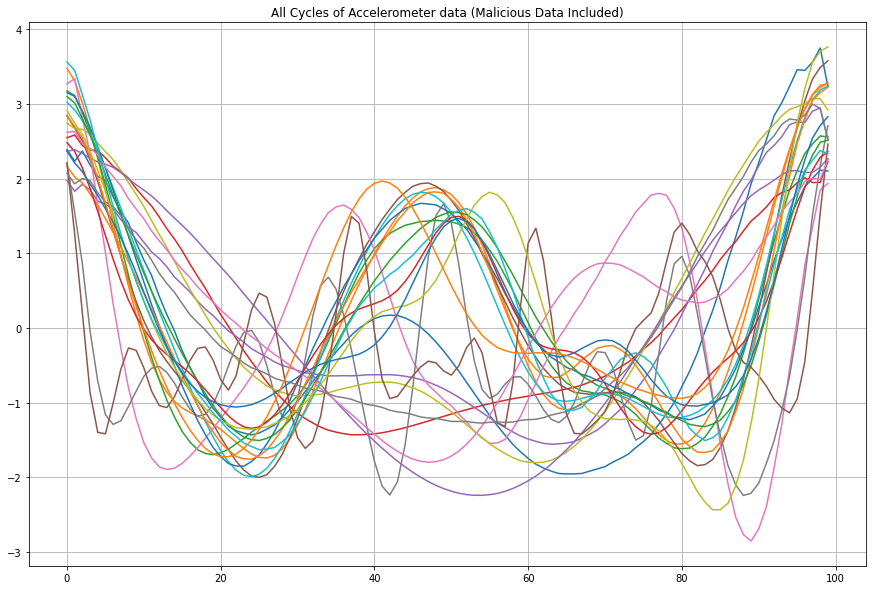

In [47]:
fig = plt.figure(figsize = (15,10))


for i in range(0,len(firstsegAcc)):
    plt.plot(firstsegAcc[i])
plt.title('All Cycles of Accelerometer data (Malicious Data Included)')
plt.grid()
plt.show()


<h2>Visualising segmented data with all malicious data removed</h2>

In [49]:
segAcc_nonmal[6]

array([ 2.93084269e+00,  2.86290210e+00,  2.65988023e+00,  2.33711699e+00,
        1.90496911e+00,  1.39823307e+00,  8.55505389e-01,  3.26073095e-01,
       -1.47005998e-01, -5.25439687e-01, -7.88369154e-01, -9.29244234e-01,
       -9.61272230e-01, -9.09520680e-01, -8.10006374e-01, -6.99237053e-01,
       -6.11538547e-01, -5.70951443e-01, -5.91921080e-01, -6.76639403e-01,
       -8.19691682e-01, -1.00868433e+00, -1.22953020e+00, -1.46669743e+00,
       -1.70642581e+00, -1.93529073e+00, -2.14155811e+00, -2.31309828e+00,
       -2.43844747e+00, -2.50555846e+00, -2.50371225e+00, -2.42371667e+00,
       -2.26081382e+00, -2.01576430e+00, -1.69746138e+00, -1.32300348e+00,
       -9.17965370e-01, -5.13648966e-01, -1.44016867e-01,  1.59456858e-01,
        3.71939603e-01,  4.79123362e-01,  4.78452010e-01,  3.78692654e-01,
        1.97098165e-01, -4.41307572e-02, -3.21481378e-01, -6.12472987e-01,
       -8.96403411e-01, -1.15395408e+00, -1.36631891e+00, -1.51536298e+00,
       -1.58451119e+00, -

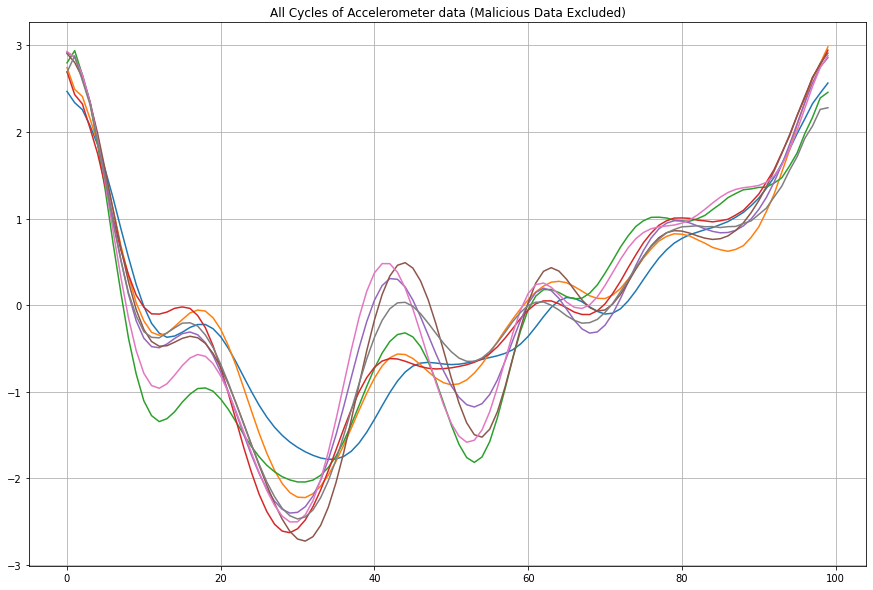

In [50]:
fig = plt.figure(figsize = (15,10))


for i in range(0,len(segAcc_nonmal)):
    plt.plot(segAcc_nonmal[i])
plt.title('All Cycles of Accelerometer data (Malicious Data Excluded)')
plt.grid()
plt.show()

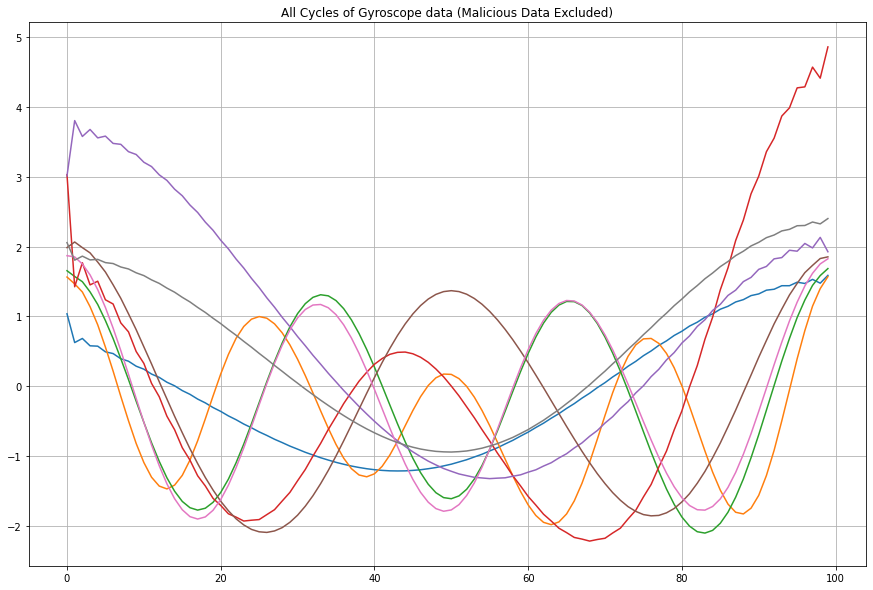

In [51]:
fig = plt.figure(figsize = (15,10))


for i in range(0,len(segGyr_nonmal)):
    plt.plot(segGyr_nonmal[i])
plt.title('All Cycles of Gyroscope data (Malicious Data Excluded)')
plt.grid()
plt.show()

<h2>Bringing the sensor data into a dataframe for input into the Neural Network</h2>

**Structure of the Data Frame:**

Each row corresonds to all the datapoints in one cycle of Accelerometer and Gyroscope data. Thus, there will be 200 columnns of datapoints in the data frame. Additionally, the corresponding subject number, gait type and the corresponding label number for the gait type are also appended in the columns.

A single input to the Neural Network will be one entire row which basically is 2 cycles of data points, with 100 datapoinsts being acceleration and 100 datapoints being angular velocity.

In [52]:
#%% Setting Labels
label = LabelEncoder()
finalData['label'] = label.fit_transform(finalData['Gait'])
finalData.head()  
    
    
    # Downstairs -> Label 0
    # Normal -> Label 1
    # Upstairs -> Label 2
    
    
finalData.reset_index(drop=True, inplace=True) # Resetting indices of data frame
    
    
#%% Data Balancing
# Labels of Acceleration and Gyroscope Data
labels = finalData.loc[:,'label']
    
# Counting the number of each label (0,1,2)
labelNum = labels.value_counts()
    
# Creating a dictionary for storing the number of label instances
labelDic = {}
for i in range(0,3):
    labelDic[i] = labelNum[i]
    if labelDic[i] == labelNum.min():
        minKey = i
    
    
# To balance the dataset, we need to ensure that all datasets of all gait types are 
# equal. Due to limitations in data segmentating many datasets of labels 2 and 0 (upstairs and 
# downstairs) were not able to undergo data segmentation properly and thus were skipped by the 
# program. 
    
# We need to ensure that the number of cycles of different gaits need to equal
# All labels occur as many times as the minimum number of times a label occurs
    
    
if minKey == 2:
    downstairs = finalData[finalData['label'] == 0].head(labelNum.min()).copy()
    normal = finalData[finalData['label'] == 1].head(labelNum.min()).copy()
    upstairs = finalData[finalData['label'] == 2].copy()
        
elif minKey == 0:
    downstairs = finalData[finalData['label'] == 0].copy()
    normal = finalData[finalData['label'] == 1].head(labelNum.min()).copy()
    upstairs = finalData[finalData['label'] == 2].head(labelNum.min()).copy()
        
else:
    downstairs = finalData[finalData['label'] == 0].head(labelNum.min()).copy()
    normal = finalData[finalData['label'] == 1].copy()
    upstairs = finalData[finalData['label'] == 2].head(labelNum.min()).copy()
    
    
balancedData = pd.DataFrame()
balancedData = balancedData.append([downstairs,normal,upstairs])
    
    
# Reindexing
balancedData.reset_index(drop=True, inplace=True)     
    
# Labels of Acceleration and Gyroscope Data
labels = balancedData.loc[:,'label']
    
# Counting the number of each label (0,1,2)
labelNum = labels.value_counts()

In [53]:
print(finalData)

        Gait Subject         2         3         4         5         6  \
0     normal     150  2.413766  1.872557  1.844629  1.511612  1.216527   
1     normal     150  2.742755  2.849620  2.505522  2.125995  1.622655   
2     normal     150  2.512328  2.419717  2.205391  1.884312  1.498780   
3     normal     150  2.539824  2.410292  2.189642  1.869429  1.519816   
4     normal     150  2.576637  2.486568  2.285454  1.994483  1.655020   
...      ...     ...       ...       ...       ...       ...       ...   
3679  normal     250  2.695974  2.432216  2.324240  2.042836  1.744596   
3680  normal     250  2.918249  2.864389  2.659792  2.351825  1.942629   
3681  normal     250  2.905952  2.803341  2.626947  2.340470  1.976888   
3682  normal     250  2.930843  2.862902  2.659880  2.337117  1.904969   
3683  normal     250  2.690349  2.879814  2.595008  2.316009  1.875183   

             7         8         9  ...       193       194       195  \
0     0.778121  0.406984  0.012883  ..

<h2>Implementing the Neural Network</h2>

**Details of the Neural Network Architecture:**
* Number of Hidden Layers: 1
* Number of Hidden Neurons: 136
* Number of Output Neurons: 
* Activation function for all hidden layer neurons: *Relu*
* Activation function for all output layer neurons: *Softmax*

**Details of Neural Network Training:**
* Number of Epochs: Variable depending on when the validation loss starts increasing
* Cross Validation Method: *2,5 and 10 fold*

**Model Performance Characteristics:**
* Final Confusion matrix for each cross validation: 2-fold, 5-fold and 10-fold
* All 4 performance parameters (*F-Score, Recall, Accuracy, Precision*) computed from the confusion matrix
* Average accuracy and loss computed for all the folds in each cross-validation step

<h2>Neural Network Model with 10-fold cross validation</h2>

Epoch 1/100
48/48 [==============================] - 0s 4ms/step - loss: 0.9315 - accuracy: 0.5799 - val_loss: 0.7624 - val_accuracy: 0.6959
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 0.7284 - accuracy: 0.6941 - val_loss: 0.7132 - val_accuracy: 0.7076
Epoch 3/100
48/48 [==============================] - 0s 1ms/step - loss: 0.6521 - accuracy: 0.7371 - val_loss: 0.6640 - val_accuracy: 0.7310
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5943 - accuracy: 0.7573 - val_loss: 0.6502 - val_accuracy: 0.7427
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5440 - accuracy: 0.7847 - val_loss: 0.6350 - val_accuracy: 0.7251
Epoch 6/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5287 - accuracy: 0.7880 - val_loss: 0.5855 - val_accuracy: 0.7602
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.7926 - val_loss: 0.6142 - val_accuracy: 0.7310
Epoch 8/100
4

48/48 [==============================] - 0s 1ms/step - loss: 0.1922 - accuracy: 0.9341 - val_loss: 0.5329 - val_accuracy: 0.8304
Epoch 32/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1655 - accuracy: 0.9524 - val_loss: 0.5018 - val_accuracy: 0.8421
Epoch 00032: early stopping
6/6 [==============================] - 0s 1ms/step - loss: 0.5018 - accuracy: 0.8421
Epoch 1/100
48/48 [==============================] - 0s 3ms/step - loss: 1.0034 - accuracy: 0.5486 - val_loss: 0.8531 - val_accuracy: 0.6374
Epoch 2/100
48/48 [==============================] - 0s 2ms/step - loss: 0.7537 - accuracy: 0.6758 - val_loss: 0.6856 - val_accuracy: 0.7018
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 0.6661 - accuracy: 0.7228 - val_loss: 0.6321 - val_accuracy: 0.7193
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.6283 - accuracy: 0.7371 - val_loss: 0.6522 - val_accuracy: 0.6725
Epoch 5/100
48/48 [==============================] -

48/48 [==============================] - 0s 1ms/step - loss: 0.2717 - accuracy: 0.8963 - val_loss: 0.5590 - val_accuracy: 0.7895
Epoch 22/100
48/48 [==============================] - 0s 1ms/step - loss: 0.2406 - accuracy: 0.9159 - val_loss: 0.5055 - val_accuracy: 0.8012
Epoch 23/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2293 - accuracy: 0.9256 - val_loss: 0.5799 - val_accuracy: 0.7953
Epoch 24/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2207 - accuracy: 0.9211 - val_loss: 0.5228 - val_accuracy: 0.8070
Epoch 25/100
48/48 [==============================] - 0s 1ms/step - loss: 0.2096 - accuracy: 0.9295 - val_loss: 0.5168 - val_accuracy: 0.7953
Epoch 26/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2045 - accuracy: 0.9309 - val_loss: 0.5117 - val_accuracy: 0.8012
Epoch 27/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1994 - accuracy: 0.9315 - val_loss: 0.5407 - val_accuracy: 0.7778
Epoch 28/100
48/48 

48/48 [==============================] - 0s 1ms/step - loss: 0.5031 - accuracy: 0.8057 - val_loss: 0.5531 - val_accuracy: 0.7882
Epoch 8/100
48/48 [==============================] - 0s 1ms/step - loss: 0.4772 - accuracy: 0.8188 - val_loss: 0.5681 - val_accuracy: 0.7471
Epoch 9/100
48/48 [==============================] - 0s 1ms/step - loss: 0.4706 - accuracy: 0.8136 - val_loss: 0.5184 - val_accuracy: 0.8118
Epoch 10/100
48/48 [==============================] - 0s 1ms/step - loss: 0.4163 - accuracy: 0.8409 - val_loss: 0.5756 - val_accuracy: 0.7941
Epoch 11/100
48/48 [==============================] - 0s 1ms/step - loss: 0.4027 - accuracy: 0.8468 - val_loss: 0.4898 - val_accuracy: 0.8000
Epoch 12/100
48/48 [==============================] - 0s 1ms/step - loss: 0.3852 - accuracy: 0.8605 - val_loss: 0.5248 - val_accuracy: 0.7824
Epoch 13/100
48/48 [==============================] - 0s 2ms/step - loss: 0.3742 - accuracy: 0.8592 - val_loss: 0.5255 - val_accuracy: 0.7765
Epoch 14/100
48/48 [=

48/48 [==============================] - 0s 1ms/step - loss: 0.6789 - accuracy: 0.7001 - val_loss: 0.6742 - val_accuracy: 0.6765
Epoch 4/100
48/48 [==============================] - 0s 1ms/step - loss: 0.6098 - accuracy: 0.7484 - val_loss: 0.6817 - val_accuracy: 0.6882
Epoch 5/100
48/48 [==============================] - 0s 1ms/step - loss: 0.5561 - accuracy: 0.7842 - val_loss: 0.6355 - val_accuracy: 0.7412
Epoch 6/100
48/48 [==============================] - 0s 1ms/step - loss: 0.5317 - accuracy: 0.7901 - val_loss: 0.6296 - val_accuracy: 0.7235
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.4979 - accuracy: 0.8070 - val_loss: 0.5969 - val_accuracy: 0.7235
Epoch 8/100
48/48 [==============================] - 0s 1ms/step - loss: 0.4888 - accuracy: 0.8162 - val_loss: 0.5718 - val_accuracy: 0.7529
Epoch 9/100
48/48 [==============================] - 0s 2ms/step - loss: 0.4507 - accuracy: 0.8201 - val_loss: 0.5786 - val_accuracy: 0.7882
Epoch 10/100
48/48 [=====

48/48 [==============================] - 0s 1ms/step - loss: 0.2109 - accuracy: 0.9257 - val_loss: 0.5707 - val_accuracy: 0.8471
Epoch 30/100
48/48 [==============================] - 0s 1ms/step - loss: 0.2083 - accuracy: 0.9329 - val_loss: 0.5617 - val_accuracy: 0.8353
Epoch 00030: early stopping
6/6 [==============================] - 0s 1ms/step - loss: 0.5617 - accuracy: 0.8353
Epoch 1/100
48/48 [==============================] - 0s 4ms/step - loss: 0.9931 - accuracy: 0.5671 - val_loss: 0.7338 - val_accuracy: 0.6882
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 0.7115 - accuracy: 0.6962 - val_loss: 0.6843 - val_accuracy: 0.6941
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 0.6371 - accuracy: 0.7419 - val_loss: 0.6343 - val_accuracy: 0.7176
Epoch 4/100
48/48 [==============================] - 0s 1ms/step - loss: 0.5887 - accuracy: 0.7575 - val_loss: 0.6155 - val_accuracy: 0.7765
Epoch 5/100
48/48 [==============================] -

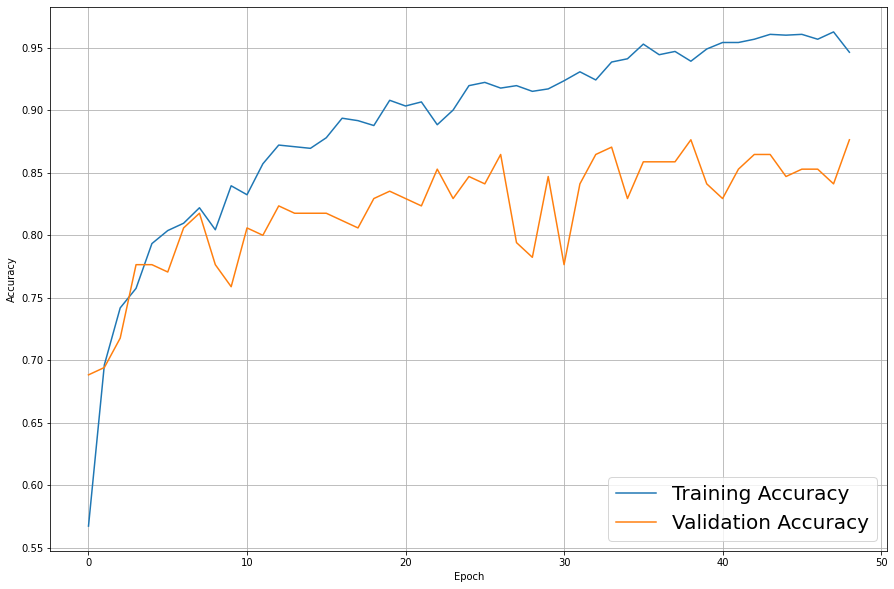

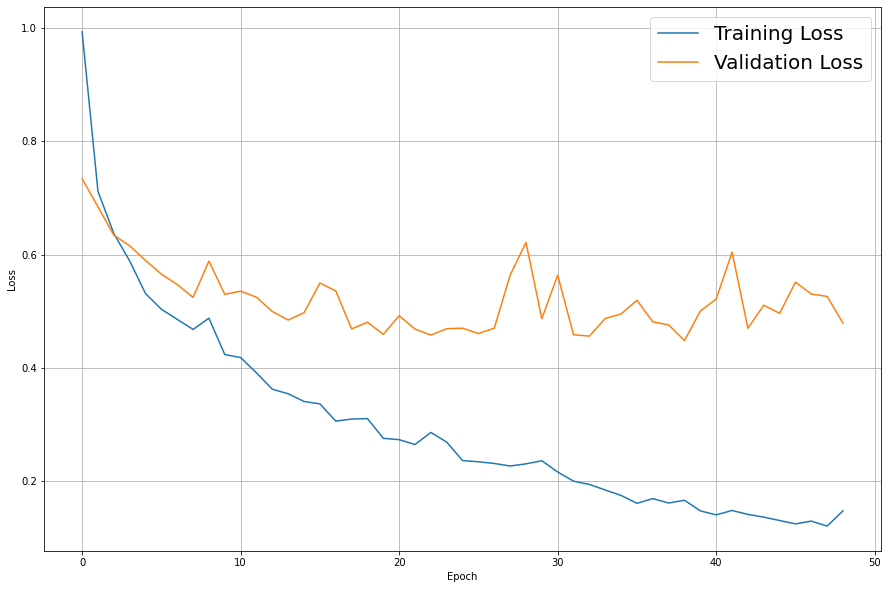

2    60
1    58
0    52
Name: label, dtype: int64
0    516
1    510
2    508
Name: label, dtype: int64


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

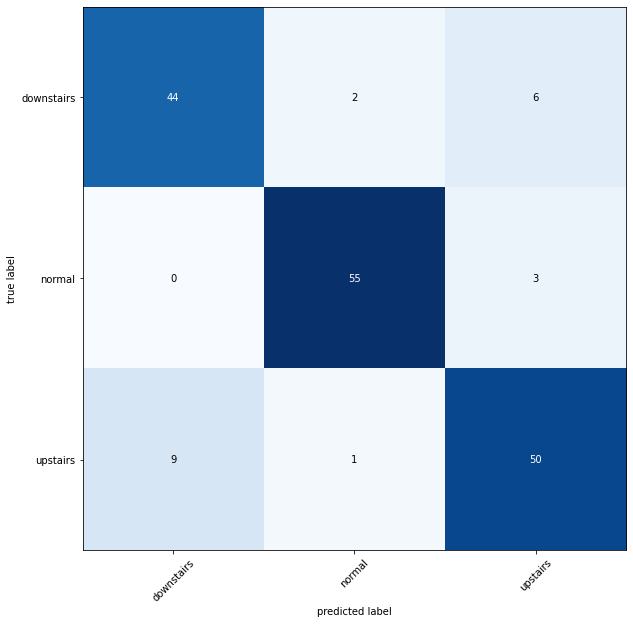

In [58]:
#%% Importing Modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, rfft, rfftfreq # For FFT
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint


#%% Neural Network

#%% Obtaining pre-processed data

f=balancedData.iloc[:,2:202]
g=balancedData.iloc[:,202]


X = f
y = g

# Number of Folds for cross-validation
numFolds = 10

#Initiating an empty array to store the accuracy and loss for each fold

acu = np.zeros(numFolds)
los = np.zeros(numFolds)
count = 0

kf = KFold(n_splits=numFolds, shuffle = True)
kf.get_n_splits(X)
# print(kf)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print(train_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
#     print(X_train, y_train)
#     print(X_train.shape)
#    print(y_test.value_counts())
#    print(y_train.value_counts())
    

    #y_pred = forest.predict(X_test[:])
    #print('Test Accuracy: %.3f' % accuracy_score(y_test, y_pred))

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(200,)), 
        tf.keras.layers.Dense(136, activation ='relu'),
        #tf.keras.layers.Dense(93, activation ='relu'),
        # tf.keras.layers.Dense(5, activation ='relu'),
        tf.keras.layers.Dense(3, activation ='softmax')
        ])
        
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    # train the neural network for 5 training epochs
    epochNum = 100 # Number of epochs
    
    #batchSize = 10
    
    # Without epoch early stopping
    # history = model.fit(X_train, y_train, epochs = epochNum, validation_data = (X_test, y_test), verbose = 1);
        
    # With epoch early stopping
    callback_a = ModelCheckpoint(filepath='my_best_mode.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochNum, callbacks=[callback_a, callback_b])
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1);
    
    # Appending the loss and accuracy values in a numpy array
    acu[count] = accuracy
    los[count] = loss
    count = count+1

#print(los, '\n\n', acu)
# Printing mean losses and accuracies across all folds
print('Loss=', np.mean(los))
print('accuracy=', np.mean(acu))


# Plotting Accuracies and Losses
 
def plot_learningCurve(history, epochs):
    #Plot training & validation accuracy values
    fig = plt.figure(figsize = (15,10))
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc = 'upper left')
    plt.show()
    plt.grid()

    #Plot training & validation loss values
    fig = plt.figure(figsize = (15,10))
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc = 'upper left')
    plt.show()
    plt.grid()
    
    
# plot_learningCurve(history, epochNum) # Plotting without epoch stopping

# Plotting with epoch stopping

# Accuracy
fig = plt.figure(figsize = (15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right',prop = {"size": 20} )
plt.grid()
plt.show()



# Loss
fig = plt.figure(figsize = (15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right',prop = {"size": 20})
plt.grid()
plt.show()



#%% Checking Data Balance
print(y_test.value_counts())
print(y_train.value_counts())


#%% Computing Confusion Matrix
y_pred = model.predict(X_test)
classes_x = np.argmax(y_pred,axis=1)

mat = confusion_matrix(y_test, classes_x)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=False, figsize = (10,10))


<h2>Performance Characteristics</h2>

In [66]:
#%% Performance Parameters from Confusion Matrix

# For each label(gait), there will be true positive, true negative, false positive, false negative

# Empty Lists for all positives and negatives
TP = np.empty((3))
TN = np.empty((3))
FP = np.empty((3))
FN = np.empty((3))
accuracy = np.empty((3))
precision = np.empty((3))
recall = np.empty((3))
f_score = np.empty((3))
for i in range(0,3):
    TP[i] = mat[i,i]
    TN[i] = mat.trace() - mat[i,i]
    FP[i] = mat[:,i].sum() - mat[i,i]
    FN[i] = mat[i,:].sum() - mat[i,i]
    accuracy[i] = (TP[i] + TN[i])/(TP[i] + TN[i] + FP[i] + FN[i])
    precision[i] = (TP[i])/(TP[i] + FP[i])
    recall[i] = (TP[i])/(TP[i] + FN[i])
    f_score[i] = 2*(precision[i])*(recall[i])/(precision[i] + recall[i])

f_scoreModel = f_score.mean()

In [60]:
print(f_scoreModel) # F-score

0.875569078205995


<h2>Neural Network Model with 5-fold cross validation</h2>

Epoch 1/100
43/43 [==============================] - 0s 3ms/step - loss: 0.9724 - accuracy: 0.5737 - val_loss: 0.8333 - val_accuracy: 0.6276
Epoch 2/100
43/43 [==============================] - 0s 2ms/step - loss: 0.7781 - accuracy: 0.6618 - val_loss: 0.7363 - val_accuracy: 0.6774
Epoch 3/100
43/43 [==============================] - 0s 1ms/step - loss: 0.6917 - accuracy: 0.6977 - val_loss: 0.6783 - val_accuracy: 0.7390
Epoch 4/100
43/43 [==============================] - 0s 2ms/step - loss: 0.6287 - accuracy: 0.7447 - val_loss: 0.6652 - val_accuracy: 0.7038
Epoch 5/100
43/43 [==============================] - 0s 2ms/step - loss: 0.5875 - accuracy: 0.7469 - val_loss: 0.6405 - val_accuracy: 0.7449
Epoch 6/100
43/43 [==============================] - 0s 2ms/step - loss: 0.5541 - accuracy: 0.7777 - val_loss: 0.6956 - val_accuracy: 0.7067
Epoch 7/100
43/43 [==============================] - 0s 2ms/step - loss: 0.5419 - accuracy: 0.7748 - val_loss: 0.6210 - val_accuracy: 0.7419
Epoch 8/100
4

Epoch 24/100
43/43 [==============================] - 0s 2ms/step - loss: 0.2539 - accuracy: 0.9068 - val_loss: 0.5218 - val_accuracy: 0.8182
Epoch 25/100
43/43 [==============================] - 0s 2ms/step - loss: 0.2435 - accuracy: 0.9200 - val_loss: 0.5635 - val_accuracy: 0.7977
Epoch 26/100
43/43 [==============================] - 0s 2ms/step - loss: 0.2523 - accuracy: 0.9120 - val_loss: 0.5297 - val_accuracy: 0.8270
Epoch 27/100
43/43 [==============================] - 0s 2ms/step - loss: 0.2480 - accuracy: 0.9134 - val_loss: 0.5577 - val_accuracy: 0.7977
Epoch 28/100
43/43 [==============================] - 0s 2ms/step - loss: 0.2245 - accuracy: 0.9237 - val_loss: 0.5309 - val_accuracy: 0.8152
Epoch 29/100
43/43 [==============================] - 0s 1ms/step - loss: 0.2077 - accuracy: 0.9310 - val_loss: 0.5423 - val_accuracy: 0.8240
Epoch 00029: early stopping
11/11 [==============================] - 0s 1ms/step - loss: 0.5423 - accuracy: 0.8240
Epoch 1/100
43/43 [==============

43/43 [==============================] - 0s 2ms/step - loss: 0.3666 - accuracy: 0.8628 - val_loss: 0.5928 - val_accuracy: 0.7889
Epoch 15/100
43/43 [==============================] - 0s 1ms/step - loss: 0.3536 - accuracy: 0.8767 - val_loss: 0.5738 - val_accuracy: 0.7771
Epoch 16/100
43/43 [==============================] - 0s 1ms/step - loss: 0.3389 - accuracy: 0.8782 - val_loss: 0.5562 - val_accuracy: 0.7918
Epoch 17/100
43/43 [==============================] - 0s 2ms/step - loss: 0.3235 - accuracy: 0.8826 - val_loss: 0.6032 - val_accuracy: 0.7478
Epoch 18/100
43/43 [==============================] - 0s 2ms/step - loss: 0.3430 - accuracy: 0.8628 - val_loss: 0.5534 - val_accuracy: 0.7771
Epoch 19/100
43/43 [==============================] - 0s 2ms/step - loss: 0.2915 - accuracy: 0.8944 - val_loss: 0.5528 - val_accuracy: 0.7889
Epoch 20/100
43/43 [==============================] - 0s 2ms/step - loss: 0.2945 - accuracy: 0.8951 - val_loss: 0.5934 - val_accuracy: 0.7654
Epoch 21/100
43/43 

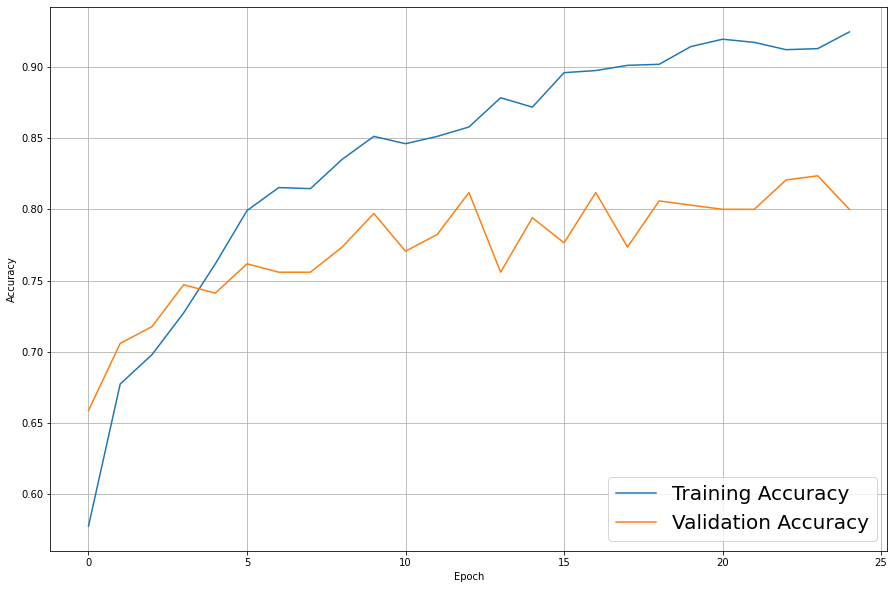

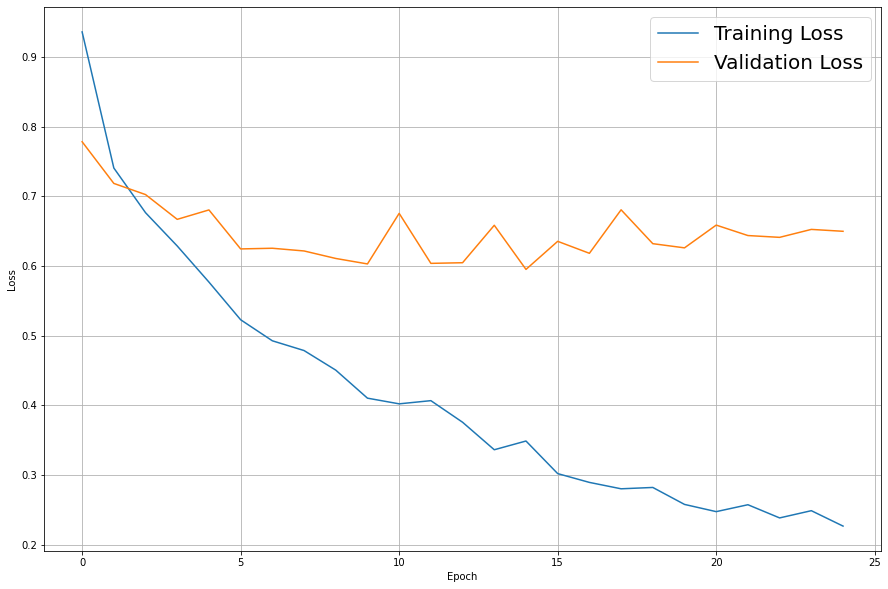

1    118
0    115
2    107
Name: label, dtype: int64
2    461
0    453
1    450
Name: label, dtype: int64


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

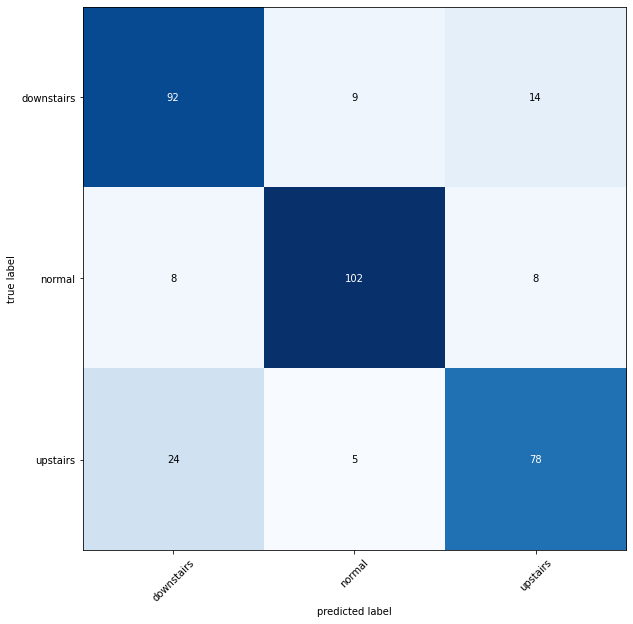

In [56]:
#%% Importing Modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, rfft, rfftfreq # For FFT
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint


#%% Neural Network

#%% Obtaining pre-processed data

f=balancedData.iloc[:,2:202]
g=balancedData.iloc[:,202]


X = f
y = g

# Number of Folds for cross-validation
numFolds = 5

#Initiating an empty array to store the accuracy and loss for each fold

acu = np.zeros(numFolds)
los = np.zeros(numFolds)
count = 0

kf = KFold(n_splits=numFolds, shuffle = True)
kf.get_n_splits(X)
# print(kf)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print(train_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
#     print(X_train, y_train)
#     print(X_train.shape)
#    print(y_test.value_counts())
#    print(y_train.value_counts())
    

    #y_pred = forest.predict(X_test[:])
    #print('Test Accuracy: %.3f' % accuracy_score(y_test, y_pred))

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(200,)), 
        tf.keras.layers.Dense(136, activation ='relu'),
        #tf.keras.layers.Dense(93, activation ='relu'),
        # tf.keras.layers.Dense(5, activation ='relu'),
        tf.keras.layers.Dense(3, activation ='softmax')
        ])
        
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    # train the neural network for 5 training epochs
    epochNum = 100 # Number of epochs
    
    #batchSize = 10
    
    # Without epoch early stopping
    # history = model.fit(X_train, y_train, epochs = epochNum, validation_data = (X_test, y_test), verbose = 1);
        
    # With epoch early stopping
    callback_a = ModelCheckpoint(filepath='my_best_mode.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochNum, callbacks=[callback_a, callback_b])
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1);
    
    # Appending the loss and accuracy values in a numpy array
    acu[count] = accuracy
    los[count] = loss
    count = count+1

#print(los, '\n\n', acu)
# Printing mean losses and accuracies across all folds
print('Loss=', np.mean(los))
print('accuracy=', np.mean(acu))


# Plotting Accuracies and Losses
 
def plot_learningCurve(history, epochs):
    #Plot training & validation accuracy values
    fig = plt.figure(figsize = (15,10))
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc = 'upper left')
    plt.show()
    plt.grid()

    #Plot training & validation loss values
    fig = plt.figure(figsize = (15,10))
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc = 'upper left')
    plt.show()
    plt.grid()
    
    
# plot_learningCurve(history, epochNum) # Plotting without epoch stopping

# Plotting with epoch stopping

# Accuracy
fig = plt.figure(figsize = (15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right',prop = {"size": 20} )
plt.grid()
plt.show()



# Loss
fig = plt.figure(figsize = (15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right',prop = {"size": 20})
plt.grid()
plt.show()



#%% Checking Data Balance
print(y_test.value_counts())
print(y_train.value_counts())


#%% Computing Confusion Matrix
y_pred = model.predict(X_test)
classes_x = np.argmax(y_pred,axis=1)

mat = confusion_matrix(y_test, classes_x)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=False, figsize = (10,10))


<h2>Performance Characteristics</h2>

In [61]:
#%% Performance Parameters from Confusion Matrix

# For each label(gait), there will be true positive, true negative, false positive, false negative

# Empty Lists for all positives and negatives
TP = np.empty((3))
TN = np.empty((3))
FP = np.empty((3))
FN = np.empty((3))
accuracy = np.empty((3))
precision = np.empty((3))
recall = np.empty((3))
f_score = np.empty((3))
for i in range(0,3):
    TP[i] = mat[i,i]
    TN[i] = mat.trace() - mat[i,i]
    FP[i] = mat[:,i].sum() - mat[i,i]
    FN[i] = mat[i,:].sum() - mat[i,i]
    accuracy[i] = (TP[i] + TN[i])/(TP[i] + TN[i] + FP[i] + FN[i])
    precision[i] = (TP[i])/(TP[i] + FP[i])
    recall[i] = (TP[i])/(TP[i] + FN[i])
    f_score[i] = 2*(precision[i])*(recall[i])/(precision[i] + recall[i])

f_scoreModel = f_score.mean()

In [62]:
print(f_scoreModel)

0.875569078205995


<h2>Neural Network Model with 2-fold cross validation</h2>

Epoch 1/100
27/27 [==============================] - 0s 6ms/step - loss: 1.1370 - accuracy: 0.4707 - val_loss: 0.8257 - val_accuracy: 0.6526
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 0.8238 - accuracy: 0.6408 - val_loss: 0.7808 - val_accuracy: 0.6984
Epoch 3/100
27/27 [==============================] - 0s 2ms/step - loss: 0.7431 - accuracy: 0.6772 - val_loss: 0.7660 - val_accuracy: 0.6831
Epoch 4/100
27/27 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.7124 - val_loss: 0.6942 - val_accuracy: 0.6878
Epoch 5/100
27/27 [==============================] - 0s 2ms/step - loss: 0.6498 - accuracy: 0.7336 - val_loss: 0.7056 - val_accuracy: 0.7183
Epoch 6/100
27/27 [==============================] - 0s 3ms/step - loss: 0.6113 - accuracy: 0.7606 - val_loss: 0.6687 - val_accuracy: 0.7113
Epoch 7/100
27/27 [==============================] - 0s 2ms/step - loss: 0.6015 - accuracy: 0.7617 - val_loss: 0.6447 - val_accuracy: 0.7183
Epoch 8/100
2

Epoch 27/100
27/27 [==============================] - 0s 2ms/step - loss: 0.2357 - accuracy: 0.9155 - val_loss: 0.6662 - val_accuracy: 0.7641
Epoch 28/100
27/27 [==============================] - 0s 3ms/step - loss: 0.2208 - accuracy: 0.9178 - val_loss: 0.6764 - val_accuracy: 0.7559
Epoch 29/100
27/27 [==============================] - 0s 3ms/step - loss: 0.2047 - accuracy: 0.9413 - val_loss: 0.6176 - val_accuracy: 0.7946
Epoch 30/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1999 - accuracy: 0.9378 - val_loss: 0.6519 - val_accuracy: 0.7817
Epoch 31/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.9401 - val_loss: 0.6353 - val_accuracy: 0.7993
Epoch 32/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1911 - accuracy: 0.9366 - val_loss: 0.6454 - val_accuracy: 0.7969
Epoch 00032: early stopping
27/27 [==============================] - 0s 843us/step - loss: 0.6454 - accuracy: 0.7969
Loss= 0.6097449064254761
accura

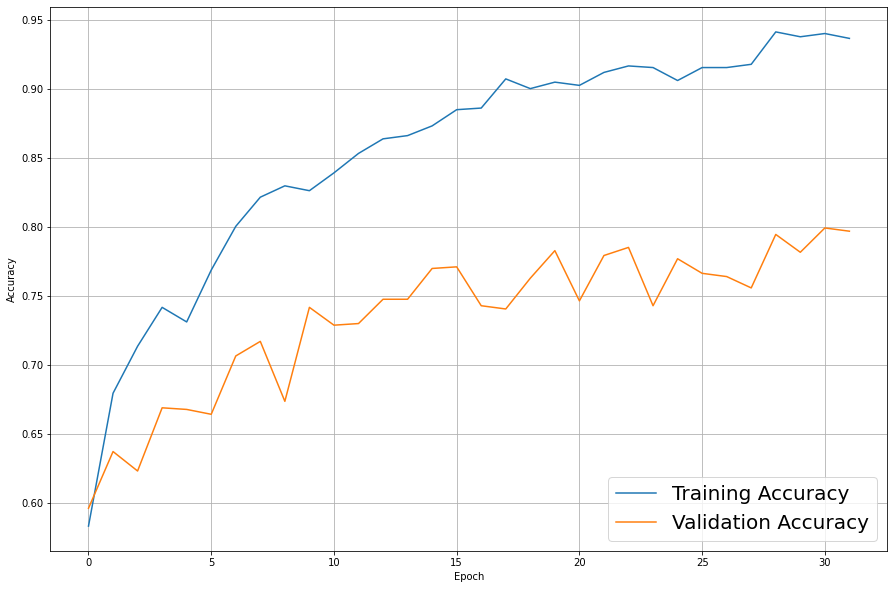

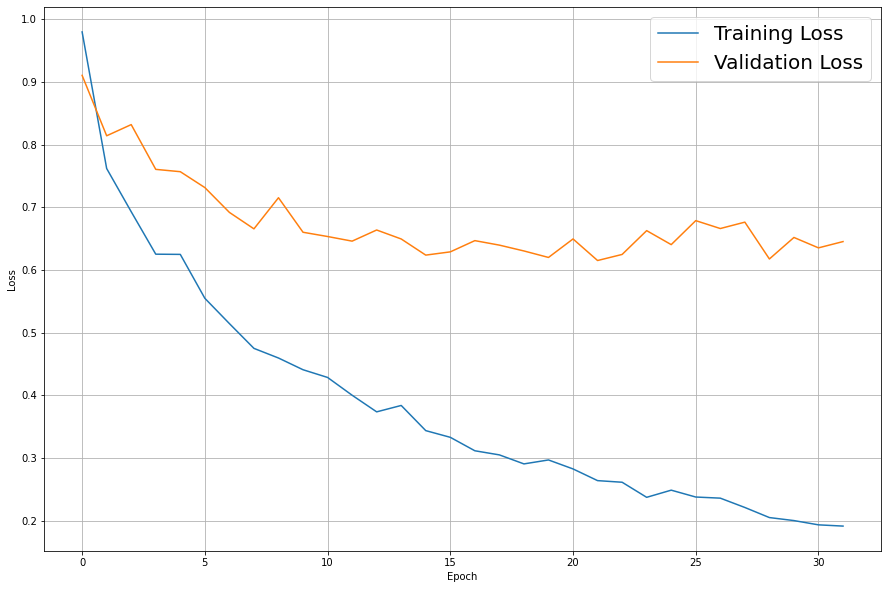

0    301
2    278
1    273
Name: label, dtype: int64
1    295
2    290
0    267
Name: label, dtype: int64


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

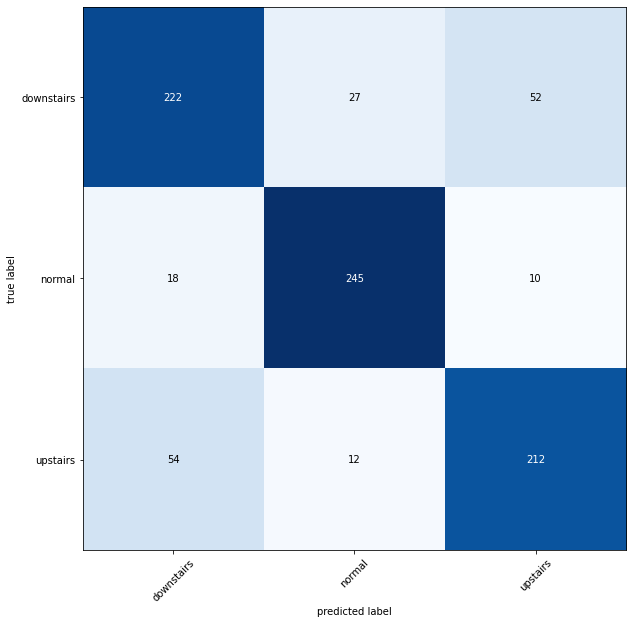

In [63]:
#%% Importing Modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, rfft, rfftfreq # For FFT
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint


#%% Neural Network

#%% Obtaining pre-processed data

f=balancedData.iloc[:,2:202]
g=balancedData.iloc[:,202]


X = f
y = g

# Number of Folds for cross-validation
numFolds = 2

#Initiating an empty array to store the accuracy and loss for each fold

acu = np.zeros(numFolds)
los = np.zeros(numFolds)
count = 0

kf = KFold(n_splits=numFolds, shuffle = True)
kf.get_n_splits(X)
# print(kf)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print(train_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
#     print(X_train, y_train)
#     print(X_train.shape)
#    print(y_test.value_counts())
#    print(y_train.value_counts())
    

    #y_pred = forest.predict(X_test[:])
    #print('Test Accuracy: %.3f' % accuracy_score(y_test, y_pred))

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(200,)), 
        tf.keras.layers.Dense(136, activation ='relu'),
        #tf.keras.layers.Dense(93, activation ='relu'),
        # tf.keras.layers.Dense(5, activation ='relu'),
        tf.keras.layers.Dense(3, activation ='softmax')
        ])
        
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    # train the neural network for 5 training epochs
    epochNum = 100 # Number of epochs
    
    #batchSize = 10
    
    # Without epoch early stopping
    # history = model.fit(X_train, y_train, epochs = epochNum, validation_data = (X_test, y_test), verbose = 1);
        
    # With epoch early stopping
    callback_a = ModelCheckpoint(filepath='my_best_mode.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochNum, callbacks=[callback_a, callback_b])
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1);
    
    # Appending the loss and accuracy values in a numpy array
    acu[count] = accuracy
    los[count] = loss
    count = count+1

#print(los, '\n\n', acu)
# Printing mean losses and accuracies across all folds
print('Loss=', np.mean(los))
print('accuracy=', np.mean(acu))


# Plotting Accuracies and Losses
 
def plot_learningCurve(history, epochs):
    #Plot training & validation accuracy values
    fig = plt.figure(figsize = (15,10))
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc = 'upper left')
    plt.show()
    plt.grid()

    #Plot training & validation loss values
    fig = plt.figure(figsize = (15,10))
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc = 'upper left')
    plt.show()
    plt.grid()
    
    
# plot_learningCurve(history, epochNum) # Plotting without epoch stopping

# Plotting with epoch stopping

# Accuracy
fig = plt.figure(figsize = (15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right',prop = {"size": 20} )
plt.grid()
plt.show()



# Loss
fig = plt.figure(figsize = (15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right',prop = {"size": 20})
plt.grid()
plt.show()



#%% Checking Data Balance
print(y_test.value_counts())
print(y_train.value_counts())


#%% Computing Confusion Matrix
y_pred = model.predict(X_test)
classes_x = np.argmax(y_pred,axis=1)

mat = confusion_matrix(y_test, classes_x)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=False, figsize = (10,10))


<h2>Performance Characteristics</h2>

In [64]:
#%% Performance Parameters from Confusion Matrix

# For each label(gait), there will be true positive, true negative, false positive, false negative

# Empty Lists for all positives and negatives
TP = np.empty((3))
TN = np.empty((3))
FP = np.empty((3))
FN = np.empty((3))
accuracy = np.empty((3))
precision = np.empty((3))
recall = np.empty((3))
f_score = np.empty((3))
for i in range(0,3):
    TP[i] = mat[i,i]
    TN[i] = mat.trace() - mat[i,i]
    FP[i] = mat[:,i].sum() - mat[i,i]
    FN[i] = mat[i,:].sum() - mat[i,i]
    accuracy[i] = (TP[i] + TN[i])/(TP[i] + TN[i] + FP[i] + FN[i])
    precision[i] = (TP[i])/(TP[i] + FP[i])
    recall[i] = (TP[i])/(TP[i] + FN[i])
    f_score[i] = 2*(precision[i])*(recall[i])/(precision[i] + recall[i])

f_scoreModel = f_score.mean()

In [65]:
print(f_scoreModel) # F-score

0.7980157254273706
